# Finetuning Named Entity Recognition using Trainer

This is almost the same as the `03-gmb-ner-bert.ipynb` notebook except that we use the HuggingFace Trainer API to do the fine-tuning instead of native PyTorch.

There are a number of advantages to using the Trainer API. First your code is less verbose and you automatically have access to best practices that are directly inbuilt into the Trainer API.

The Trainer API works on datasets directly. You don't have to create a DataLoader explicitly.

However, you do have to honor the expectations of the Trainer API. For example, the version of the `compute_metrics` function takes an `EvalPrediction` object rather than a pair of list of lists. So you need to learn a little more about the `Trainer` and `TrainerArguments` API but the benefits are quite good.

In addition, we have switched out the BERT model for a larger and more powerful XLM-RoBERTa model, and as a result we see slightly better results from the trained model on the test split.

## Environment Setup

In [ ]:
!pip install transformers datasets seqeval

     |████████████████████████████████| 3.8 MB 9.0 MB/s 
     |████████████████████████████████| 325 kB 39.8 MB/s 
     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 6.5 MB 42.7 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 29.2 MB/s 
     |████████████████████████████████| 895 kB 13.1 MB/s 
     |████████████████████████████████| 1.1 MB 27.9 MB/s 
     |████████████████████████████████| 136 kB 37.9 MB/s 
     |████████████████████████████████| 212 kB 36.8 MB/s 
     |████████████████████████████████| 127 kB 40.8 MB/s 
     |████████████████████████████████| 271 kB 44.5 MB/s 
     |████████████████████████████████| 144 kB 37.9 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=03b41e5e9f5e2d7312257a83244e0ad7b31c0275c3b1dc62eaf363e921cd3cb0
  Stored in directory: /root/.cache/pip/whe

## Imports

In [ ]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoConfig,
    DataCollatorForTokenClassification,
    TrainingArguments, Trainer, get_scheduler
)

## Data Processing

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/odsc-2022-data/GMB/

bert-base-cased-gmb-ner        ner.csv
distilbert-base-cased-gmb-ner  ner_dataset.csv


In [ ]:
!head /content/drive/MyDrive/odsc-2022-data/GMB/ner_dataset.csv

Sentence #,Word,POS,Tag
Sentence: 1,Thousands,NNS,O
,of,IN,O
,demonstrators,NNS,O
,have,VBP,O
,marched,VBN,O
,through,IN,O
,London,NNP,B-geo
,to,TO,O
,protest,VB,O


In [ ]:
GS_DATA_DIR = "/content/drive/MyDrive/odsc-2022-data/GMB/"
DATA_DIR = "data"

NER_FILEPATH = os.path.join(GS_DATA_DIR, "ner_dataset.csv")

OUTPUT_FILEPATHS = [
  os.path.join(DATA_DIR, "gmb-train.jsonl"),
  os.path.join(DATA_DIR, "gmb-valid.jsonl"),
  os.path.join(DATA_DIR, "gmb-test.jsonl")
]

BASE_MODEL_NAME = "xlm-roberta-base"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-gmb-ner".format(BASE_MODEL_NAME))

In [ ]:
def write_output(tokens, labels, output_files, num_writter):
  assert(len(tokens) == len(labels))
  rec = json.dumps({ "tokens": tokens, "ner_tags": labels })
  dice = random.random()
  if dice <= 0.7:
    output_files[0].write("{:s}\n".format(rec))
    num_written[0] += 1
  elif dice <= 0.8:
    output_files[1].write("{:s}\n".format(rec))
    num_written[1] += 1
  else:
    output_files[2].write("{:s}\n".format(rec))
    num_written[2] += 1


os.makedirs(DATA_DIR, exist_ok=True)
output_files = [open(filepath, "w") for filepath in OUTPUT_FILEPATHS]
num_written = [0, 0, 0]
tokens, labels = [], []
with open(NER_FILEPATH, "r", encoding="latin-1") as fner:
  csv_reader = csv.reader(fner)
  next(csv_reader)  # skip header
  for row in csv_reader:
    if row[0].startswith("Sentence") and len(tokens) > 0:
      # write out current sentence to train / valid / test
      write_output(tokens, labels, output_files, num_written)
      tokens, labels = [], []
    # accumulate tokens and labels
    tokens.append(row[1])
    labels.append(row[3])
    # if num_written[0] > 1000:
    #   break

if len(tokens) > 0:
  write_output(tokens, labels, output_files, num_written)

[output_file.close() for output_file in output_files]
print(num_written)

[33495, 4855, 9609]


## Dataset

In [ ]:
data_files = {
    "train": OUTPUT_FILEPATHS[0],
    "validation": OUTPUT_FILEPATHS[1],
    "test": OUTPUT_FILEPATHS[2]
}
gmb_dataset = load_dataset("json", data_files=data_files)
gmb_dataset

Using custom data configuration default-9fc6980fcc26b2b1


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9fc6980fcc26b2b1/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 33495
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4855
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9609
    })
})

## Tokenizer

### Class Label Mappings

In [ ]:
entity_types = set()
for ner_tags in gmb_dataset["train"]["ner_tags"]:
  for ner_tag in ner_tags:
    if ner_tag.startswith("B-"):
      entity_types.add(ner_tag.replace("B-", ""))
entity_types = sorted(list(entity_types))

tag_names = []
for entity_type in entity_types:
  tag_names.append("B-{:s}".format(entity_type))
  tag_names.append("I-{:s}".format(entity_type))
tag_names.append("O")

tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}

# label2id, id2label

### Label Alignment

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [ ]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"], 
                               truncation=True, 
                               is_split_into_words=True)
  aligned_batch_labels = []
  for idx, labels in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    prev_word_id = None
    aligned_labels = []
    for word_id in word_ids:
      if word_id is None or word_id == prev_word_id:
        aligned_labels.append(-100)   # IGNore tag
      else:
        aligned_labels.append(label2id[labels[word_id]])
      prev_word_id = word_id
    aligned_batch_labels.append(aligned_labels)
  tokenized_inputs["labels"] = aligned_batch_labels
  return tokenized_inputs


tokens = gmb_dataset["train"][0]["tokens"]
ner_tags = gmb_dataset["train"][0]["ner_tags"]
aligned_labels = tokenize_and_align_labels(gmb_dataset["train"][0:1])["labels"][0]
len(tokens), len(ner_tags), len(aligned_labels)

(24, 24, 33)

In [ ]:
encoded_gmb_dataset = gmb_dataset.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])
encoded_gmb_dataset

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33495
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4855
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9609
    })
})

## Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                                        num_labels=len(tag_names),
                                                        id2label=id2label,
                                                        label2id=label2id)
model = model.to(device)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

## Training

Note different signatures for `compute_metrics` as opposed to compute_f1_score previously.

In [ ]:
num_epochs = 3
batch_size = 16  # larger model, lower batch size
logging_steps = len(encoded_gmb_dataset["train"]) // batch_size
model_name = "{:s}-gmb-ner".format(BASE_MODEL_NAME)
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps
)

In [ ]:
def align_predictions(labels_cpu, preds_cpu):
  # remove -100 labels from score computation
  batch_size, seq_len = preds_cpu.shape
  labels_list, preds_list = [], []
  for bid in range(batch_size):
    example_labels, example_preds = [], []
    for sid in range(seq_len):
      # ignore label -100
      if labels_cpu[bid, sid] != -100:
        example_labels.append(id2label[labels_cpu[bid, sid]])
        example_preds.append(id2label[preds_cpu[bid, sid]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return labels_list, preds_list


def compute_metrics(pred):
  # convert logits to predictions and move to CPU
  preds_cpu = np.argmax(pred.predictions, axis=-1)
  labels_cpu = pred.label_ids
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  # seqeval.metrics.f1_score takes list of list of tags
  return { "f1": f1_score(labels_list, preds_list) }


In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
config = AutoConfig.from_pretrained(BASE_MODEL_NAME, 
                                    num_labels=len(tag_names),
                                    id2label=id2label, 
                                    label2id=label2id)
def model_init():
  return (AutoModelForTokenClassification
          .from_pretrained(BASE_MODEL_NAME, config=config)
          .to(device))

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=encoded_gmb_dataset["train"],
    eval_dataset=encoded_gmb_dataset["validation"],
    tokenizer=tokenizer
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.133300,0.097612,0.824024
2,0.081800,0.089677,0.835278
3,0.060500,0.090078,0.842300


TrainOutput(global_step=6282, training_loss=0.09183237205897878, metrics={'train_runtime': 3071.602, 'train_samples_per_second': 32.714, 'train_steps_per_second': 2.045, 'total_flos': 2737684910793138.0, 'train_loss': 0.09183237205897878, 'epoch': 3.0})

## Evaluation

In [ ]:
def get_label_and_predicted_tags(examples):
  features = [dict(zip(examples, t)) for t in zip(*examples.values())]
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].cpu().numpy()
  with torch.no_grad():
    output = trainer.model(input_ids, attention_mask=attention_mask)
    predicted_label = torch.argmax(output.logits, dim=-1).cpu().numpy()
  return { 
    "labels": labels,
    "predicted_labels": predicted_label 
  }


label_list, prediction_list = [], []
val_dataset = encoded_gmb_dataset["test"].map(get_label_and_predicted_tags, batched=True)
for val_rec in val_dataset:
  labels = val_rec["labels"]
  predicted_labels = val_rec["predicted_labels"]
  for label, predicted_label in zip(labels, predicted_labels):
    if label == -100:
      continue
    label_list.append(id2label[label])
    prediction_list.append(id2label[predicted_label])

len(label_list), len(prediction_list)

Parameter 'function'=<function get_label_and_predicted_tags at 0x7fc1653793b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/10 [00:00<?, ?ba/s]

(210050, 210050)

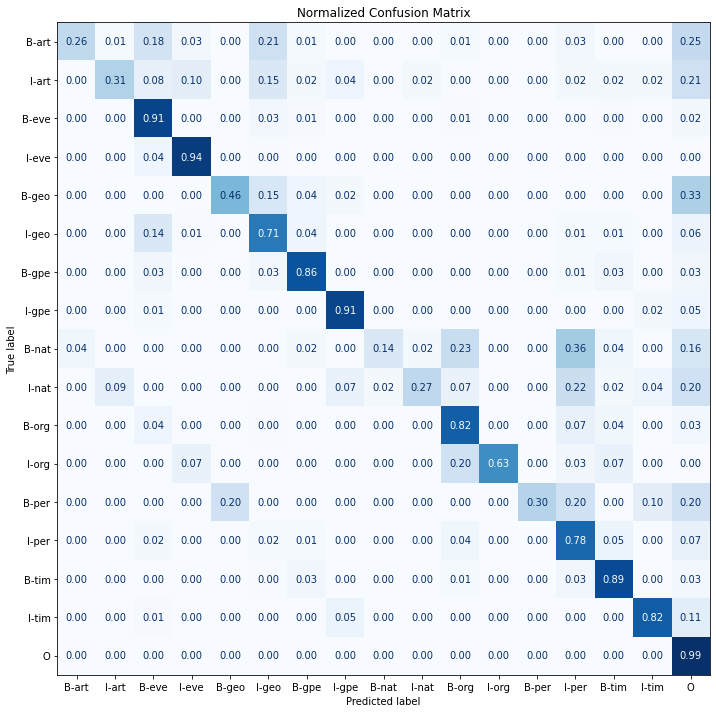

In [ ]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(label_list, prediction_list, tag_names)

## Save Model

In [ ]:
!cp -r xlm-roberta-base-gmb-ner/ /content/drive/MyDrive/odsc-2022-data/GMB/

In [ ]:
!ls /content/drive/MyDrive/odsc-2022-data/GMB/xlm-roberta-base-gmb-ner/

runs
